In [10]:
import pandas as pd
import numpy as np
from collections import defaultdict, deque
import matplotlib.pyplot as plt

In [26]:
def calculate_swmid(bids, asks):
    """Calculate Size-Weighted Mid Price exactly like original"""
    if not bids or not asks:
        return np.nan
    best_bid = max(bids.keys())
    best_ask = min(asks.keys())
    bid_vol = abs(bids[best_bid])
    ask_vol = abs(asks[best_ask])
    return (best_bid * ask_vol + best_ask * bid_vol) / (bid_vol + ask_vol)

class Backtester:
    def __init__(self, price_files, params=None):
        self.data = self.load_data(price_files)
        if params is None:
            params = {
                'default_spread_mean': 56.92,
                'default_spread_std': 80.78,
                'spread_std_window': 45,
                'zscore_threshold': 2.0,
                'target_position': 50,
            }
        self.params = params
        self.spread_history = deque(maxlen=params['spread_std_window'])
        self.position = 0
        self.pnl = 0
        self.last_price = None
        self.trades = []

    def load_data(self, files):
        """Loads data preserving full order book structure"""
        data = []
        for file in files:
            df = pd.read_csv(file, sep=';')
            for _, row in df.iterrows():
                entry = {
                    'timestamp': row['timestamp'],
                    'product': row['product'],
                    'bids': {},
                    'asks': {}
                }
                for i in range(1,4):
                    if pd.notna(row[f'bid_price_{i}']):
                        entry['bids'][row[f'bid_price_{i}']] = row[f'bid_volume_{i}']
                    if pd.notna(row[f'ask_price_{i}']):
                        entry['asks'][row[f'ask_price_{i}']] = -row[f'ask_volume_{i}']
                data.append(entry)
        return data

    def process_timestamp(self, ts_data):
        """Processes one timestamp with exact original logic"""
        # Reconstruct OrderDepth objects
        order_depths = {}
        for entry in ts_data:
            order_depths[entry['product']] = {
                'buy_orders': entry['bids'],
                'sell_orders': entry['asks']
            }

        # Calculate SWMID prices (exactly like original)
        try:
            basket_swmid = calculate_swmid(
                order_depths['PICNIC_BASKET1']['buy_orders'],
                order_depths['PICNIC_BASKET1']['sell_orders']
            )
            synth_swmid = (
                6 * calculate_swmid(order_depths['CROISSANTS']['buy_orders'], order_depths['CROISSANTS']['sell_orders']) +
                3 * calculate_swmid(order_depths['JAMS']['buy_orders'], order_depths['JAMS']['sell_orders']) +
                1 * calculate_swmid(order_depths['DJEMBES']['buy_orders'], order_depths['DJEMBES']['sell_orders'])
            )
        except KeyError as e:
            print(f"Missing product data: {e}")
            return

        spread = basket_swmid - synth_swmid
        self.spread_history.append(spread)

        # Calculate z-score (matches original logic)
        if len(self.spread_history) >= self.params['spread_std_window']:
            current_mean = np.mean(self.spread_history)
            current_std = np.std(self.spread_history)
            zscore = (spread - current_mean) / current_std
        else:
            zscore = (spread - self.params['default_spread_mean']) / self.params['default_spread_std']

        # Trading logic (matches original execute_spread_orders)
        target_pos = 0
        if zscore >= self.params['zscore_threshold']:
            target_pos = -self.params['target_position']
        elif zscore <= -self.params['zscore_threshold']:
            target_pos = self.params['target_position']

        if target_pos != self.position:
            # Execute at current SWMID (no costs)
            fill_price = basket_swmid

            # CORRECT PnL calculation:
            # Only calculate PnL change from previous position
            if self.last_price is not None:
                self.pnl += (fill_price - self.last_price) * self.position

            self.trades.append({
                'timestamp': ts_data[0]['timestamp'],
                'price': fill_price,
                'qty': target_pos - self.position,
                'zscore': zscore,
                'position': target_pos,
                'spread': spread
            })
            self.position = target_pos
            self.last_price = fill_price

    def run_backtest(self):
        """Runs complete backtest"""
        # Group data by timestamp
        timestamps = defaultdict(list)
        for entry in self.data:
            timestamps[entry['timestamp']].append(entry)

        # Process each timestamp
        for ts in sorted(timestamps.keys()):
            self.process_timestamp(timestamps[ts])

        return pd.DataFrame(self.trades)

    def analyze_results(self, results):
        """Generate comprehensive performance analysis"""
        if len(results) == 0:
            print("No trades executed!")
            return

        # Calculate cumulative PnL
        results['cum_pnl'] = 0
        if len(results) > 1:
            price_changes = results['price'].diff()
            position_changes = results['position'].shift(1)
            results['pnl'] = price_changes * position_changes
            results['cum_pnl'] = results['pnl'].cumsum()

        print("\nStrategy Performance Analysis")
        print("="*40)
        print(f"Total Trades: {len(results)}")
        print(f"Final PnL: {results['cum_pnl'].iloc[-1]:.2f}")
        print(f"Win Rate: {(results['pnl'] > 0).mean():.1%}")
        print(f"Max Drawdown: {results['cum_pnl'].cummax().subtract(results['cum_pnl']).max():.2f}")
        print("\nZ-Score Stats:")
        print(f"Max: {results['zscore'].max():.2f}")
        print(f"Min: {results['zscore'].min():.2f}")
        print(f"Avg Entry: {results.groupby('position')['zscore'].mean().to_dict()}")

        # Plotting
        plt.figure(figsize=(15,10))

        plt.subplot(3,1,1)
        plt.plot(results['timestamp'], results['cum_pnl'], label='Cumulative PnL')
        plt.scatter(results['timestamp'], results['cum_pnl'],
                   c=np.where(results['qty']>0, 'g', 'r'), label='Trades')
        plt.title("Cumulative PnL Over Time")
        plt.legend()

        plt.subplot(3,1,2)
        plt.plot(results['timestamp'], results['spread'], label='Spread')
        plt.title("Spread Evolution")

        plt.subplot(3,1,3)
        results['zscore'].hist(bins=50)
        plt.title("Z-Score Distribution at Entry")

        plt.tight_layout()
        plt.show()

Running backtest with original parameters...

Strategy Performance Analysis
Total Trades: 1098
Final PnL: 31705.64
Win Rate: 32.7%
Max Drawdown: 4366.52

Z-Score Stats:
Max: 3.69
Min: -3.84
Avg Entry: {-50: 2.2820332732461632, 0: 0.07621348975990772, 50: -2.2754635694067242}


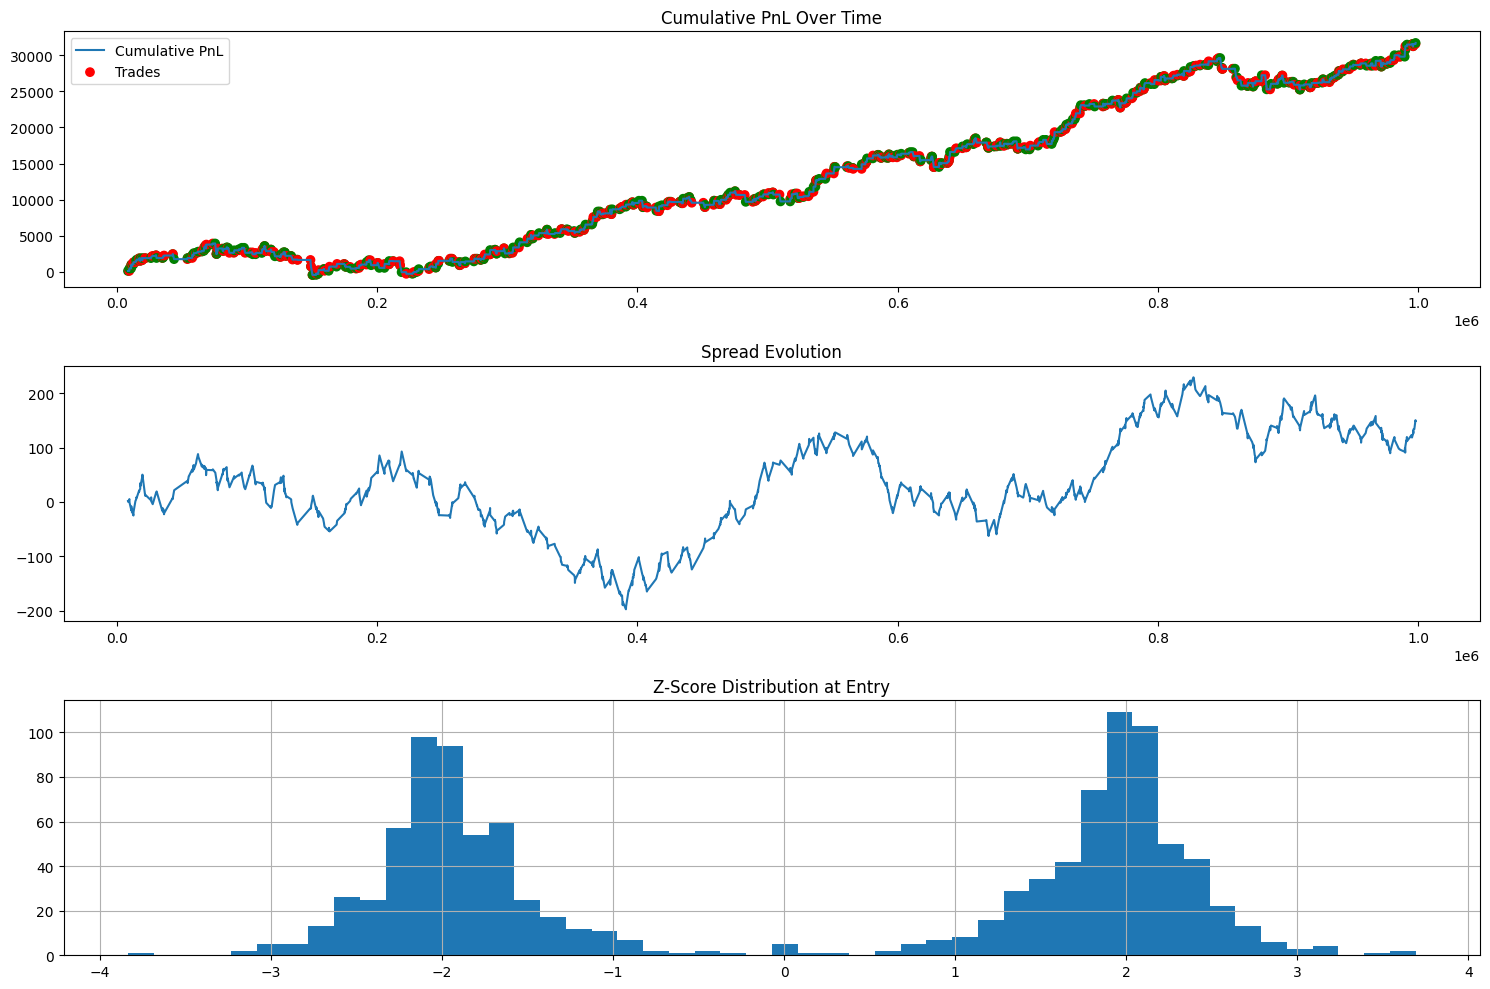

In [42]:
4# Complete workflow example
# 1. Run backtest with original parameters
print("Running backtest with original parameters...")
original_backtester = Backtester(
    [
        '../data/prices_round_2_day_-1.csv',
        '../data/prices_round_2_day_0.csv',
        '../data/prices_round_2_day_1.csv'
    ],
    params={
        'default_spread_mean': 56.92,
        'default_spread_std': 80.78,
        'spread_std_window': 45,
        'zscore_threshold': 2,  # Original threshold
        'target_position': 50   # Original position
    }
)
original_results = original_backtester.run_backtest()
original_backtester.analyze_results(original_results)

In [44]:
def optimize_parameters(price_files):
    """Complete parameter optimization with fixed PnL calculation"""
    # Parameter ranges to test
    param_grid = {
        'zscore_threshold': np.arange(0.5, 3.5, 0.5),
        'target_position': [45, 50, 58],
        'spread_std_window': [30, 45, 60]
    }

    best_params = None
    best_sharpe = -np.inf
    results = []

    # Grid search
    from itertools import product
    for threshold, position, window in product(
            param_grid['zscore_threshold'],
            param_grid['target_position'],
            param_grid['spread_std_window']
    ):
        bt = Backtester(price_files, params={
            'default_spread_mean': 56.92,
            'default_spread_std': 80.78,
            'spread_std_window': window,
            'zscore_threshold': threshold,
            'target_position': position
        })
        trades = bt.run_backtest()

        if len(trades) > 5:  # Require minimum trades
            # Calculate returns properly
            trades['price_change'] = trades['price'].diff()
            trades['position_change'] = trades['position'].shift(1)
            trades['daily_pnl'] = trades['price_change'] * trades['position_change']
            returns = trades['daily_pnl'].dropna()

            sharpe = returns.mean() / returns.std() if returns.std() > 0 else 0
            total_pnl = returns.sum()

            results.append({
                'threshold': threshold,
                'position': position,
                'window': window,
                'sharpe': sharpe,
                'trades': len(trades),
                'pnl': total_pnl
            })

            if sharpe > best_sharpe:
                best_sharpe = sharpe
                best_params = {
                    'zscore_threshold': threshold,
                    'target_position': position,
                    'spread_std_window': window
                }

    # Optimization results
    print("\nOptimization Complete")
    print("="*40)
    print(f"Best Sharpe Ratio: {best_sharpe:.2f}")
    print("Best Parameters:")
    for k, v in best_params.items():
        print(f"{k}: {v}")

    # Convert results to DataFrame for analysis
    results_df = pd.DataFrame(results)

    # Plot optimization surface
    fig = plt.figure(figsize=(15,5))

    ax1 = fig.add_subplot(131)
    for pos in param_grid['target_position']:
        subset = results_df[results_df['position'] == pos]
        ax1.plot(subset['threshold'], subset['sharpe'], label=f'Pos={pos}')
    ax1.set_title('Sharpe by Position')
    ax1.legend()

    ax2 = fig.add_subplot(132)
    for thresh in param_grid['zscore_threshold']:
        subset = results_df[results_df['threshold'] == thresh]
        ax2.plot(subset['position'], subset['sharpe'], label=f'Thresh={thresh:.1f}')
    ax2.set_title('Sharpe by Threshold')
    ax2.legend()

    ax3 = fig.add_subplot(133)
    for window in param_grid['spread_std_window']:
        subset = results_df[results_df['window'] == window]
        ax3.plot(subset['threshold'], subset['sharpe'], label=f'Window={window}')
    ax3.set_title('Sharpe by Window')
    ax3.legend()

    plt.tight_layout()
    plt.show()

    return best_params


Optimizing parameters...

Optimization Complete
Best Sharpe Ratio: 0.17
Best Parameters:
zscore_threshold: 2.0
target_position: 50
spread_std_window: 30


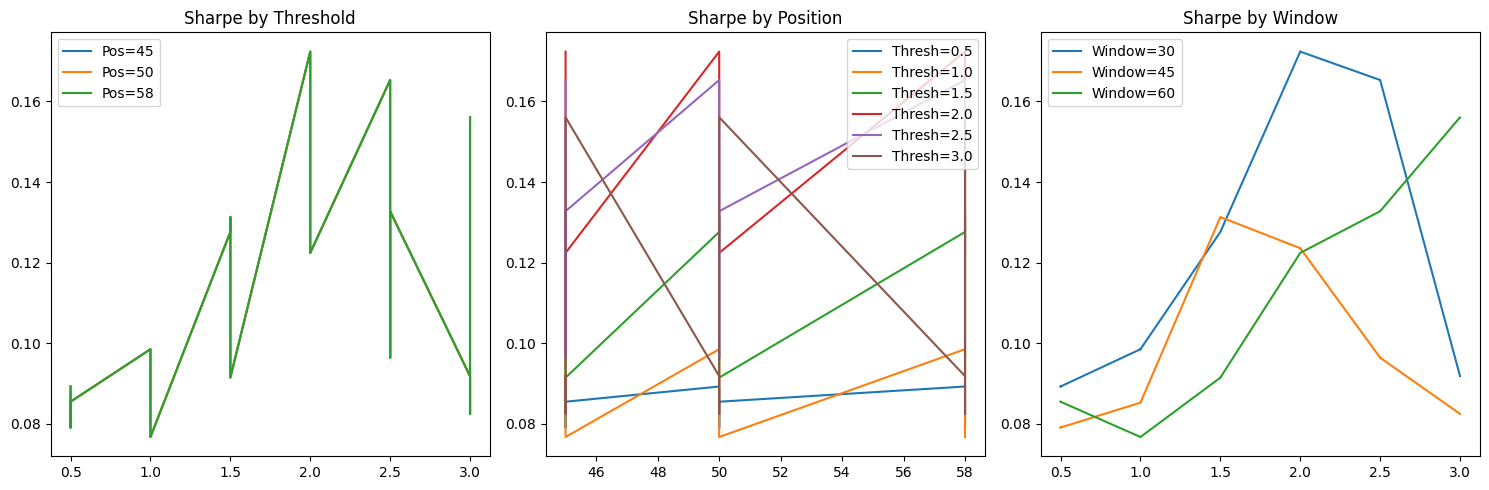

In [45]:
# 2. Optimize parameters
print("\nOptimizing parameters...")
best_params = optimize_parameters(
    [
        '../data/prices_round_2_day_-1.csv',
        '../data/prices_round_2_day_0.csv',
        '../data/prices_round_2_day_1.csv'
    ],
)


Running backtest with optimized parameters...

Strategy Performance Analysis
Total Trades: 1268
Final PnL: 46998.73
Win Rate: 32.5%
Max Drawdown: 3676.92

Z-Score Stats:
Max: 3.38
Min: -3.20
Avg Entry: {-50: 2.2828572906381885, 0: 0.21632677809400816, 50: -2.303993472073242}


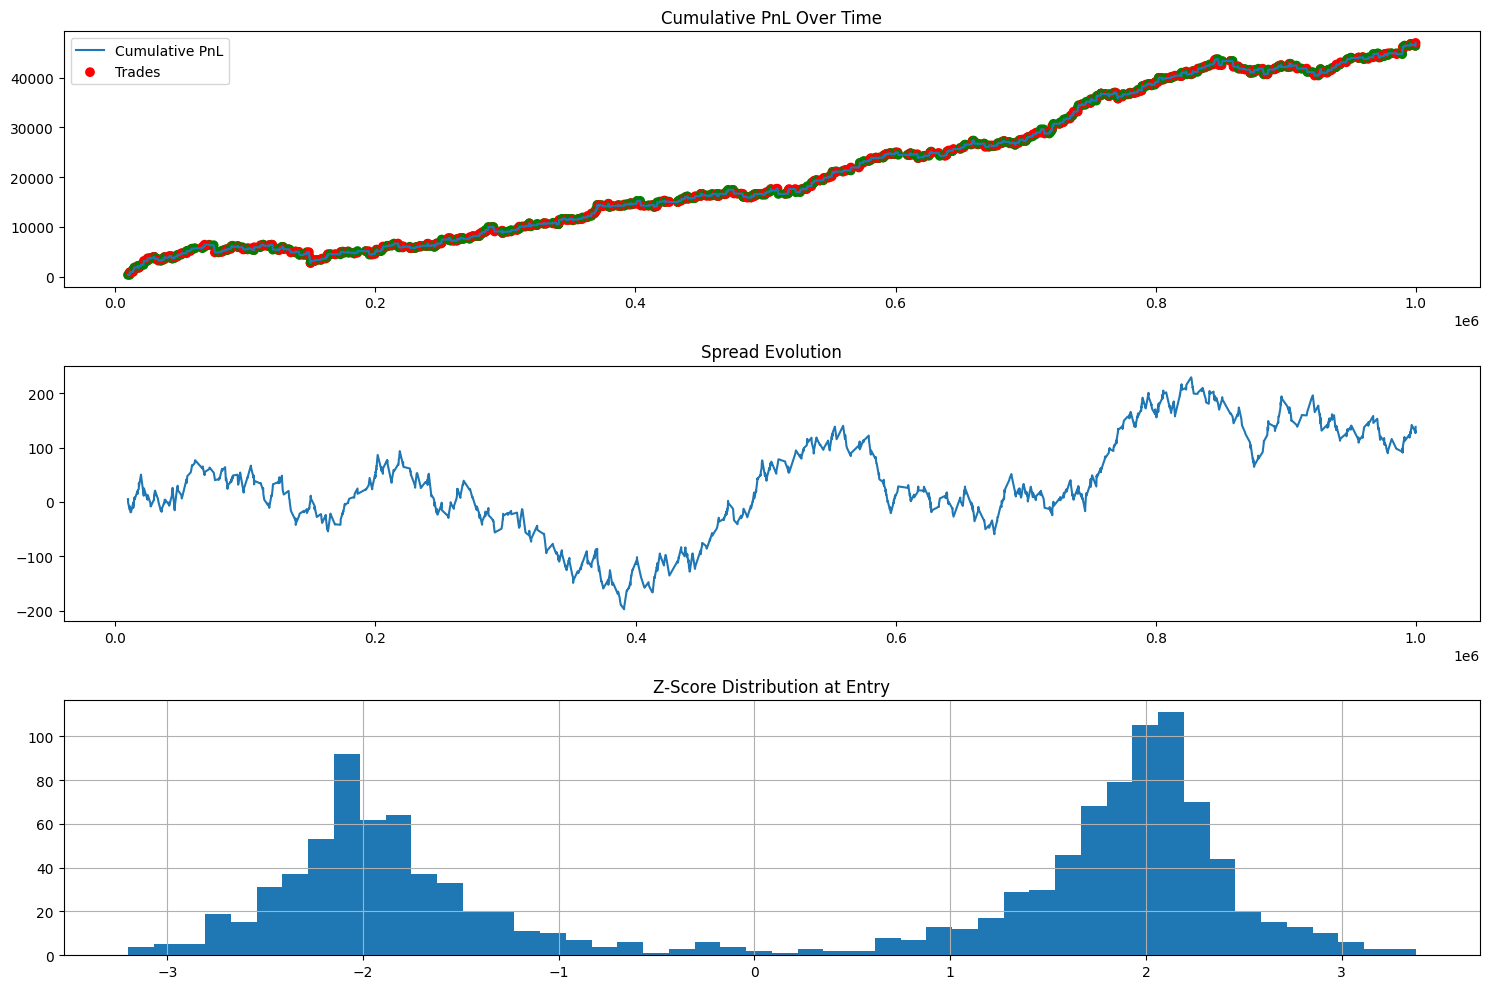

In [46]:
# 3. Run with optimized parameters
print("\nRunning backtest with optimized parameters...")
optimized_backtester = Backtester(
    [
        '../data/prices_round_2_day_-1.csv',
        '../data/prices_round_2_day_0.csv',
        '../data/prices_round_2_day_1.csv'
    ],
    params={
        'default_spread_mean': 56.92,
        'default_spread_std': 80.78,
        **best_params
    }
)
optimized_results = optimized_backtester.run_backtest()
optimized_backtester.analyze_results(optimized_results)